# Notebook for exercise 1 

## 0. Get data ready

### 0.1 Create train and test sets

In [67]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting
import numpy as np

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)

file_names.append("test_batch")

for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 0.2 Preprocessing the data
From task 0 i am going to use:
* StandardScaler
* PCA

I have seen from the previous exercise that these two, improve my accuracy

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#PCA
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)






In [69]:
X_train.shape, X_test.shape

(torch.Size([50000, 100]), torch.Size([10000, 100]))

### 0.3 Device agnostic code

In [70]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Build a linear model

### 1.1 Build a linear model



In [71]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use only linear layers (No ReLU)
class linear_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model1_linear = linear_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model1_linear

linear_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Create Loss function and Optimizer

* I am wokring on a multiclass classification problem, so i will use the `nn.CrossEntropyLoss()` method as my loss function.
* For the optimizer i will use the Stochastic Gradient Descent (`SGD`)

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1_linear.parameters(),
                            lr=0.1)


### 1.3 Create train and test loop function

In [73]:
#put the data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    def reset(self):
        self.train_loss_values[:] = np.nan
        self.test_loss_values[:] = np.nan
        self.train_acc_values[:] = np.nan
        self.test_acc_values[:] = np.nan
    
    

In [74]:
from sklearn.metrics import accuracy_score 
import time

def train_test_fn(model,epochs,X_train,X_test,y_train,y_test,metrics):
    metrics.reset() # Reset metrics before each call
    start_time = time.time()  # Start the timer
    
    for epoch in range(epochs):
        ### Training
        model.train()
        #1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1) # logits -> pred probabilities -> pred labels
        #2. Calculate loss and accuracy
        loss = loss_fn(y_logits,y_train)
        metrics.train_loss_values[epoch] = loss
        # train_loss_values[epoch] = loss
        acc = accuracy_score(y_train.cpu(),y_pred.cpu())
        metrics.train_acc_values[epoch] = acc
        # train_acc_values[epoch] = acc
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backwards
        loss.backward()
        #5.Optimizer step
        optimizer.step()
    
        ###Testing
        model.eval()
        with torch.inference_mode():
            #1. Forward pass
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            #2. Calculate the test loss and accuracy
            test_loss = loss_fn(test_logits,y_test)
            metrics.test_loss_values[epoch] = test_loss
            # test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu(),test_pred.cpu())
            metrics.test_acc_values[epoch] = test_acc
            # test_acc_values[epoch] = test_acc

        #Print the results
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    end_time = time.time()  # End the timer
    total_time = end_time - start_time  # Calculate total time
    print(f"Training completed in: {total_time:.2f} seconds")





In [75]:
epochs =100

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model1_linear,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics)

Epoch: 0 | Loss: 2.78279, Acc: 0.09% | Test Loss: 6.24608, Test Acc: 0.21%
Epoch: 10 | Loss: 1.88127, Acc: 0.34% | Test Loss: 1.84308, Test Acc: 0.35%
Epoch: 20 | Loss: 1.77372, Acc: 0.39% | Test Loss: 1.77058, Test Acc: 0.39%
Epoch: 30 | Loss: 1.76316, Acc: 0.39% | Test Loss: 1.76115, Test Acc: 0.39%
Epoch: 40 | Loss: 1.77028, Acc: 0.39% | Test Loss: 1.77300, Test Acc: 0.38%
Epoch: 50 | Loss: 1.74936, Acc: 0.40% | Test Loss: 1.74788, Test Acc: 0.40%
Epoch: 60 | Loss: 1.74012, Acc: 0.40% | Test Loss: 1.74064, Test Acc: 0.40%
Epoch: 70 | Loss: 1.73780, Acc: 0.40% | Test Loss: 1.73905, Test Acc: 0.40%
Epoch: 80 | Loss: 1.74120, Acc: 0.40% | Test Loss: 1.74432, Test Acc: 0.40%
Epoch: 90 | Loss: 1.74518, Acc: 0.40% | Test Loss: 1.74723, Test Acc: 0.40%
Epoch: 99 | Loss: 1.73922, Acc: 0.40% | Test Loss: 1.73929, Test Acc: 0.40%
Training completed in: 4.61 seconds


### 1.4 Save the `model1_linear` in `Ex1_Models` folder

In [76]:
from pathlib import Path

def save_model(model,model_name):
    #1. Create models directory
    MODEL_PATH = Path("Ex1_Models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    #2. Create model save path
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    #3. save the model state dict
    print(f"Saving model to:{MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)


In [77]:
save_model(model=model1_linear,
           model_name="model1_linear.pth")

Saving model to:Ex1_Models\model1_linear.pth


### 1.5 Plot the `model1_liner`

In [78]:
import matplotlib.pyplot as plt

def plot_loss_acc_fn(metrics,model_name):
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss (" + model_name + ")" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
    

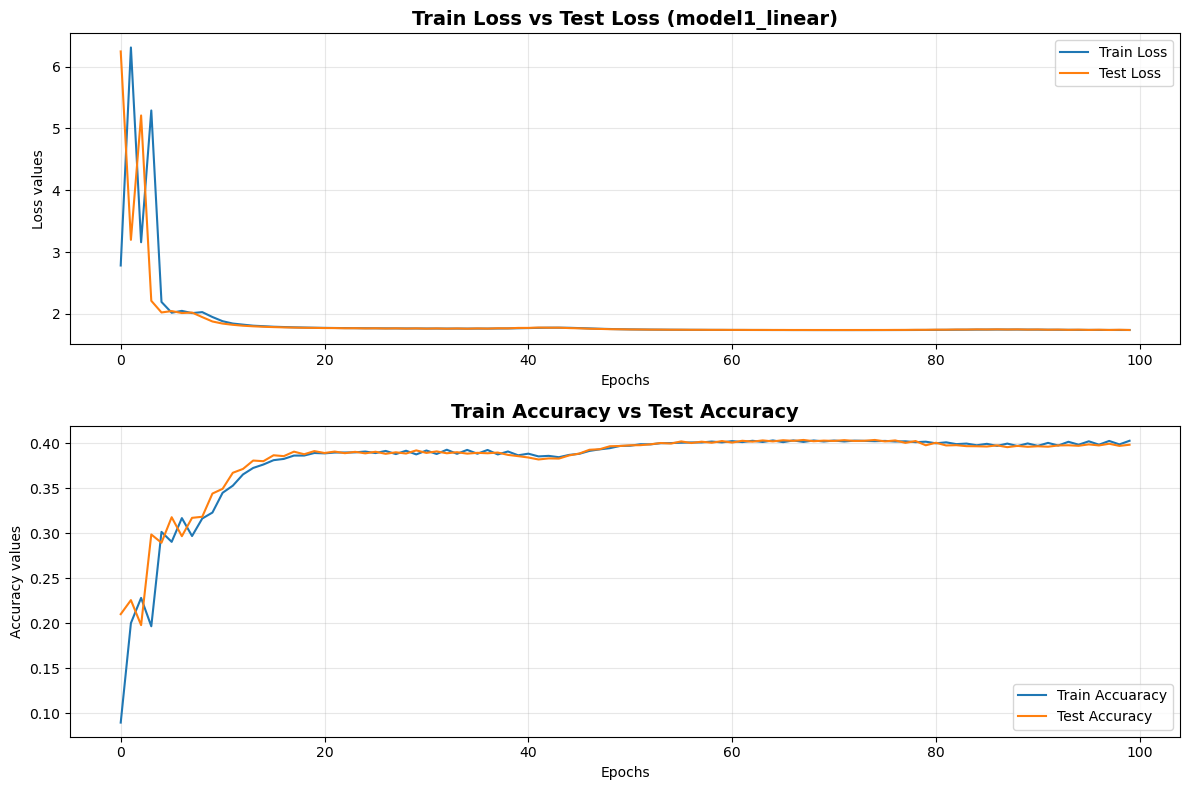

In [79]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model1_linear")

### 1.6. Conclusion

For my first attempt i used a linear model with 2 hidden layers and each hidden layer with 512 hidden units (neurons). From the start i see that my first NN model works better for the CIFAR-10 dataset than the KNN and NCC classifiers

## 2. Build a non linear model

### 2.1 Create model

Below i have a neural network with 2 hidden layers and each hidden layer has 512 hidden units.

In [157]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class relu_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model2_relu = relu_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model2_relu

relu_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 2.2 Loss function and optimizer

In [158]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2_relu.parameters(),
                            lr=0.01)

### 2.3 Train and test loop

In [159]:
# call train_test_fn to train and test my model
epochs = 500

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model2_relu,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics)

Epoch: 0 | Loss: 2.42477, Acc: 0.10% | Test Loss: 2.35213, Test Acc: 0.11%
Epoch: 50 | Loss: 1.97418, Acc: 0.30% | Test Loss: 1.96536, Test Acc: 0.32%
Epoch: 100 | Loss: 1.86533, Acc: 0.35% | Test Loss: 1.86092, Test Acc: 0.35%
Epoch: 150 | Loss: 1.80250, Acc: 0.37% | Test Loss: 1.80077, Test Acc: 0.37%
Epoch: 200 | Loss: 1.75946, Acc: 0.39% | Test Loss: 1.75981, Test Acc: 0.39%
Epoch: 250 | Loss: 1.72663, Acc: 0.40% | Test Loss: 1.72886, Test Acc: 0.40%
Epoch: 300 | Loss: 1.69991, Acc: 0.41% | Test Loss: 1.70394, Test Acc: 0.41%
Epoch: 350 | Loss: 1.67725, Acc: 0.42% | Test Loss: 1.68306, Test Acc: 0.42%
Epoch: 400 | Loss: 1.65749, Acc: 0.42% | Test Loss: 1.66517, Test Acc: 0.42%
Epoch: 450 | Loss: 1.63996, Acc: 0.43% | Test Loss: 1.64952, Test Acc: 0.43%
Epoch: 499 | Loss: 1.62451, Acc: 0.43% | Test Loss: 1.63592, Test Acc: 0.43%
Training completed in: 567.58 seconds


### 2.4 Save the `model2_relu`

In [160]:
save_model(model=model2_relu,
           model_name="model2_relu.pth")

Saving model to:Ex1_Models\model2_relu.pth


### 2.5 PLot the `model2_relu`

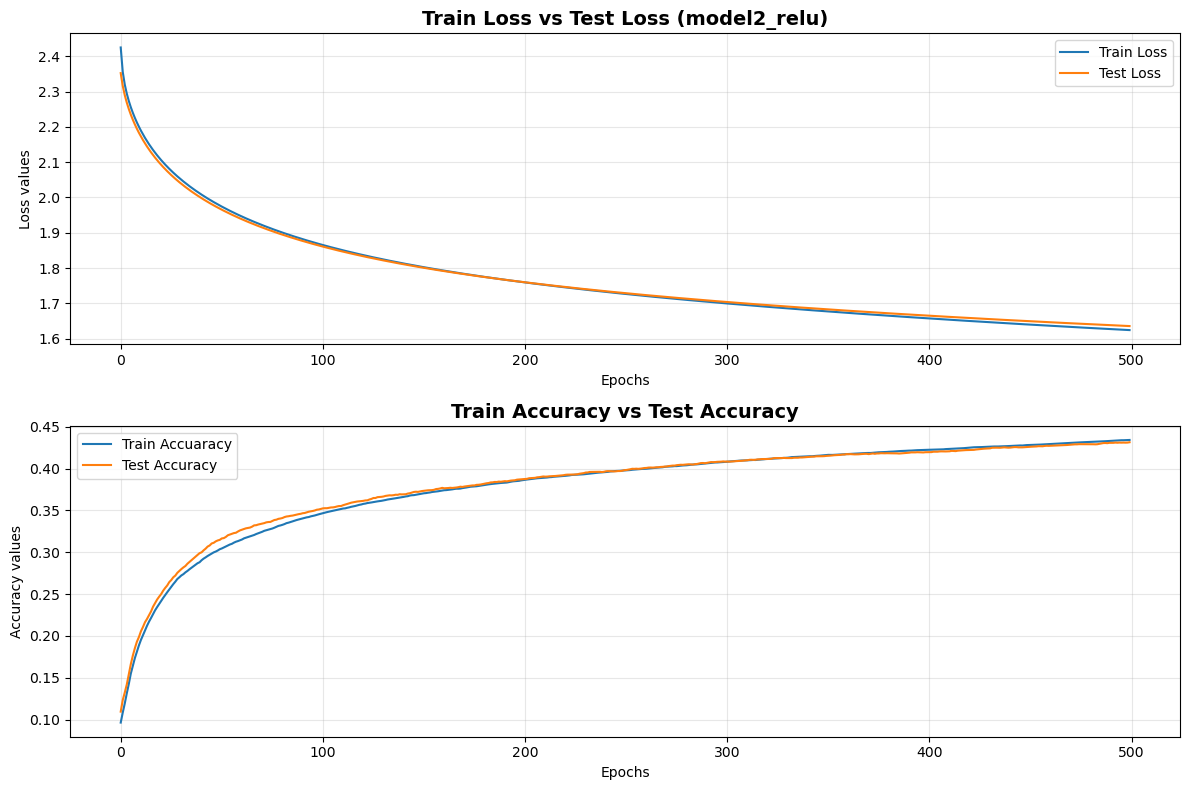

In [161]:
plot_loss_acc_fn(metrics,"model2_relu")

### 2.6 Conclusion for `model2_relu`

This non linear model has higher accuracy than the previous linear model. 

## 3 Build a non linear model with many hidden units

Now i will try to build a non linear model with many hidden units to see if it works better with the data. From `Diamantaras slides on Multilayer Perceptron` i see that i dont need more than two layers. Instead i need many hidden units

### 3.1 Create model

In [98]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class relu_units_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model3_relu_units = relu_units_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model3_relu_units

relu_units_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### 3.2 Loss function and optimizer

In [99]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model3_relu_units.parameters(),
                            lr=0.01)

### 3.3 train and test loop

In [100]:
# call train_test_fn to train and test my model
epochs =100

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model3_relu_units,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.40602, Acc: 0.10% | Test Loss: 2.30122, Test Acc: 0.14%
Epoch: 10 | Loss: 2.10800, Acc: 0.24% | Test Loss: 2.09069, Test Acc: 0.26%
Epoch: 20 | Loss: 2.01365, Acc: 0.29% | Test Loss: 2.00195, Test Acc: 0.29%
Epoch: 30 | Loss: 1.95504, Acc: 0.31% | Test Loss: 1.94630, Test Acc: 0.31%
Epoch: 40 | Loss: 1.91271, Acc: 0.33% | Test Loss: 1.90605, Test Acc: 0.33%
Epoch: 50 | Loss: 1.87969, Acc: 0.34% | Test Loss: 1.87467, Test Acc: 0.35%
Epoch: 60 | Loss: 1.85273, Acc: 0.35% | Test Loss: 1.84907, Test Acc: 0.35%
Epoch: 70 | Loss: 1.83005, Acc: 0.36% | Test Loss: 1.82757, Test Acc: 0.36%
Epoch: 80 | Loss: 1.81057, Acc: 0.37% | Test Loss: 1.80912, Test Acc: 0.37%
Epoch: 90 | Loss: 1.79354, Acc: 0.37% | Test Loss: 1.79304, Test Acc: 0.38%
Epoch: 99 | Loss: 1.77990, Acc: 0.38% | Test Loss: 1.78017, Test Acc: 0.38%
Training completed in: 14.20 seconds


### 3.4 save the `model3_relu_layers`

In [101]:
save_model(model=model3_relu_units,
           model_name="model3_relu_units.pth")

Saving model to:Ex1_Models\model3_relu_units.pth


### 3.5 Plot the `model2_relu_layers`

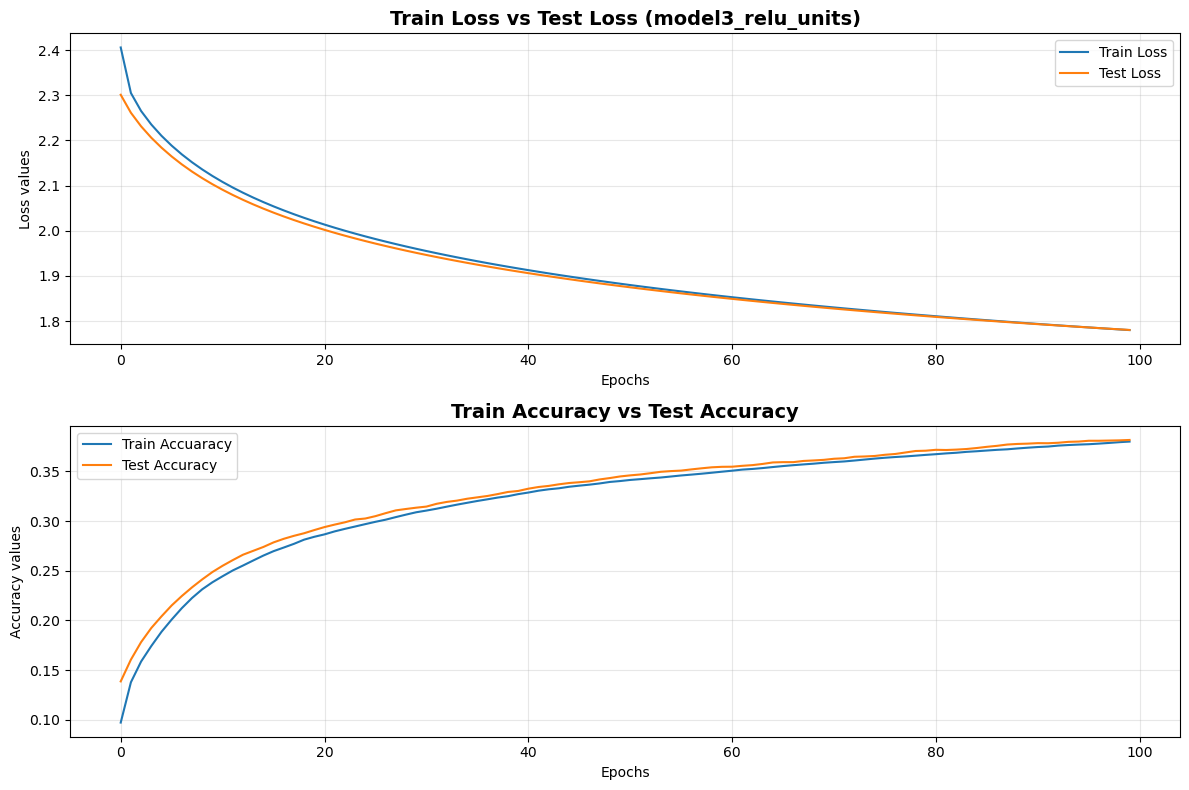

In [102]:
plot_loss_acc_fn(metrics=metrics,
                model_name="model3_relu_units")

### 3.6 Conclusion for `model3_relu_layers`

## 4. Build a deep non linear model using also momemtum

This model will have 6 hidden layers with 1024 hidden units each. I will also use momentum to help the optimizer overcome local minima.

### 4.1 Create a model

In [106]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class relu_layers_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model4_relu_layers = relu_layers_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model4_relu_layers

relu_layers_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### 4.2 Loss function and optimizer

In this model, i will use momentum in the optimizer in order to improve my non linear model.

In [108]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model4_relu_layers.parameters(),lr=0.01,momentum=0.6)

### 4.3 Train and test loop

In [126]:
# call train_test_fn to train and test my model
epochs =100

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model4_relu_layers,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.28652, Acc: 0.19% | Test Loss: 2.28628, Test Acc: 0.19%
Epoch: 10 | Loss: 2.28652, Acc: 0.19% | Test Loss: 2.28628, Test Acc: 0.19%


KeyboardInterrupt: 

### 4.4 Save the `model4_relu_layers`

In [110]:
save_model(model=model4_relu_layers,
           model_name="model4_relu_layers.pth")

Saving model to:Ex1_Models\model4_relu_layers.pth


### 4.5 Plot the `model4_relu_layers`

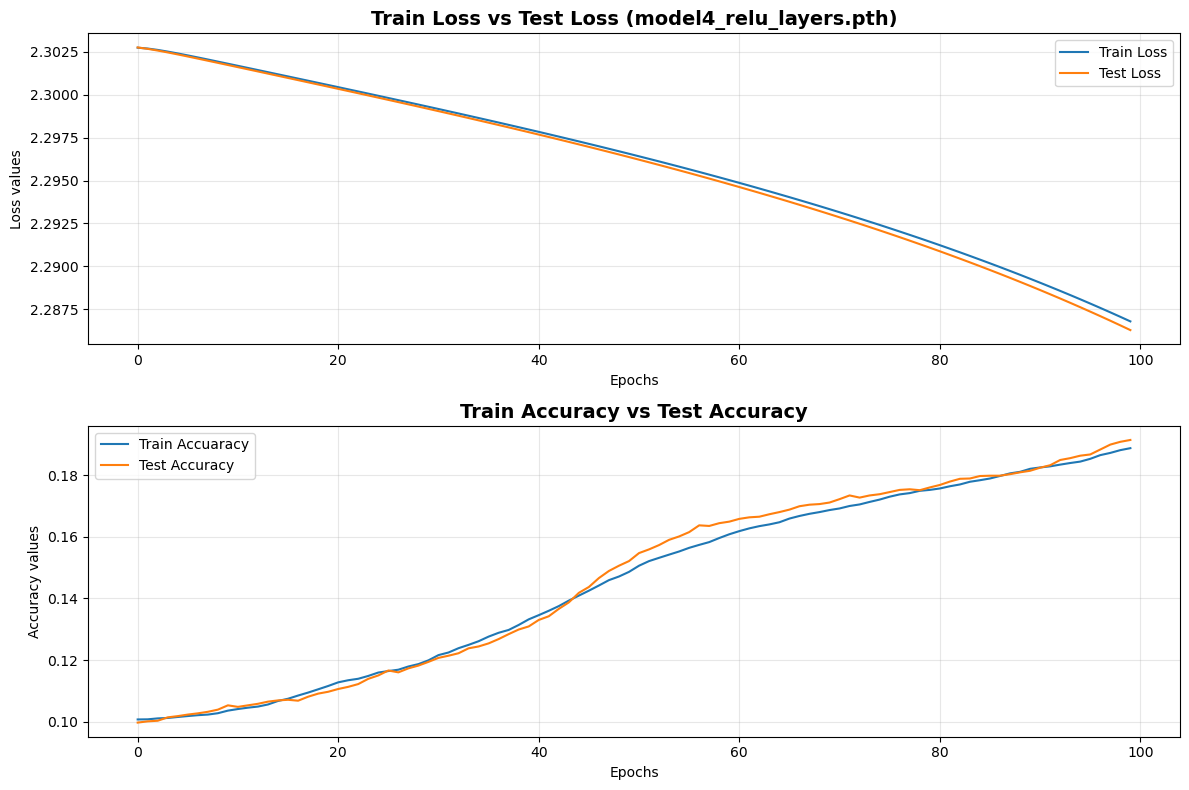

In [111]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model4_relu_layers.pth")

### 4.6 Conclusion for `model4_relu_layers`

From the `Train Loss vs Test Loss` plot is see that the momemtum made the curve smoother as expected. I also noticed that even if i add many layers , the model performs like the previous model (`model3_relu_units`) that had 2 hidden layers. 

## 5. Build a non linear model 

In this model i will use:
- Momentum
- Dropout
  

From https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/ :
1. `Use Dropout on incoming (visible) as well as hidden units. Application of Dropout at each layer of the network has shown good results.`
2. `Use a larger network. You are likely to get better performance when Dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.`
4. `Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.`
5. `Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights, such as max-norm regularization, with a size of 4 or 5 has been shown to improve results.`

So i will use dropout in every layer, i will create a deep neural network, i will use a large learning rate and momentum and i will put a constraint on the size of network weights.

### 5.1 Create a model

In [144]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class dropout_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model5_dropout = dropout_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model5_dropout

dropout_model(
  (linear_layer_stack): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=100, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1024, out_features=1024, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=1024, out_features=1024, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=1024, out_features=1024, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.2, inplace=False)
    (19): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### 5.2 Loss Function and optimizer

In [145]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model5_dropout.parameters(),lr=0.001,momentum=0.9)

### 5.3 Train and test loop

In [147]:
epochs=100
# Create a metrics object
metrics = my_Metrics(epochs)

# Assuming you have an optimizer already defined:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=, gamma=0.5)  # Decay every 10 epochs


# metrics.reset()  # Reset metrics before each call
# start_time = time.time()  # Start the timer

# for epoch in range(epochs):
#     ### Training
#     model5_dropout.train()
#     # Forward pass
#     y_logits = model5_dropout(X_train)
#     y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
#     # Calculate loss and accuracy
#     loss = loss_fn(y_logits, y_train)
#     metrics.train_loss_values[epoch] = loss
#     acc = accuracy_score(y_train.cpu(), y_pred.cpu())
#     metrics.train_acc_values[epoch] = acc
#     # Optimizer step
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     ### Testing
#     model5_dropout.eval()
#     with torch.inference_mode():
#         test_logits = model5_dropout(X_test)
#         test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
#         test_loss = loss_fn(test_logits, y_test)
#         metrics.test_loss_values[epoch] = test_loss.item()
#         test_acc = accuracy_score(y_test.cpu(), test_pred.cpu())
#         metrics.test_acc_values[epoch] = test_acc
    
#     # Scheduler step
#     # scheduler.step()

#     # Print results
#     if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
#         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | "
#               f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

# end_time = time.time()
# total_time = end_time - start_time
# print(f"Training completed in: {total_time:.2f} seconds")

train_test_fn(model=model5_dropout,
              epochs=100,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.30145, Acc: 0.10% | Test Loss: 2.30109, Test Acc: 0.12%
Epoch: 10 | Loss: 2.30124, Acc: 0.11% | Test Loss: 2.30073, Test Acc: 0.13%
Epoch: 20 | Loss: 2.30086, Acc: 0.11% | Test Loss: 2.30036, Test Acc: 0.13%
Epoch: 30 | Loss: 2.30059, Acc: 0.11% | Test Loss: 2.30000, Test Acc: 0.14%


KeyboardInterrupt: 

### 5.4 Save the `model5_dropout`

In [118]:
save_model(model=model5_dropout,model_name="model5_dropout.pth")

Saving model to:Ex1_Models\model5_dropout.pth


### 5.5 Plot `model5_dropout`

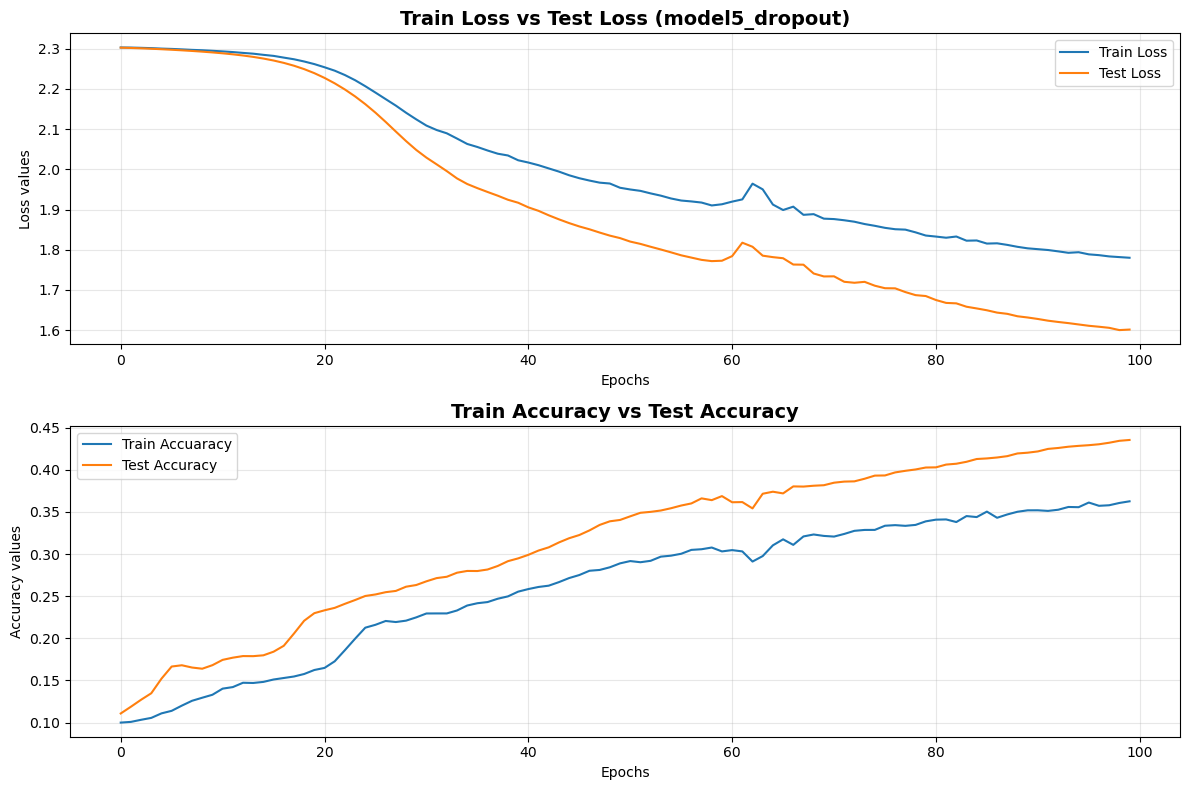

In [119]:
plot_loss_acc_fn(metrics=metrics,model_name="model5_dropout")